In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import pandas as pd
import theano.tensor as T
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In this example, our main distribution is built of two exponential distributions

In [2]:
def generate_poisson_mixtures(lams, sizes):
    grp1 = np.random.poisson(lam=lams[0], size=sizes[0])
    grp2 = np.random.poisson(lam=lams[1], size=sizes[1])
    
    mixture = np.concatenate([grp1, grp2])
    return mixture

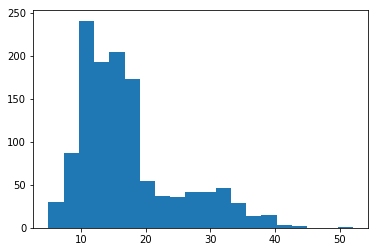

In [68]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[1000, 250])
plt.hist(mixture, bins=20)
plt.show()

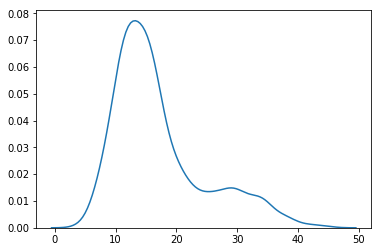

In [5]:
sns.kdeplot(mixture)

In [6]:
with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson.dist(mu=lam, shape=(2,))  # must use dist, not plain Poisson object!
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)

In [13]:
with model:
    trace = pm.sample(5000, tune=2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w_stickbreaking__, lam_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:24<00:00, 287.45it/s]


In [25]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lam__0,29.304872,0.423890,0.004380,28.446734,30.114813,9242.953179,0.999952
lam__1,13.786176,0.134754,0.001363,13.518301,14.044324,10089.315077,0.999925
w__0,0.212620,0.013354,0.000130,0.186206,0.239043,9369.646070,0.999901
w__1,0.787380,0.013354,0.000130,0.760957,0.813794,9369.646070,0.999901


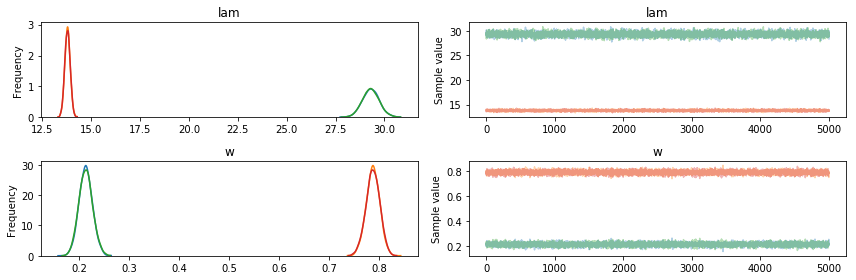

In [73]:
pm.traceplot(trace)
plt.show()

# Visualizing traced parameters on original data

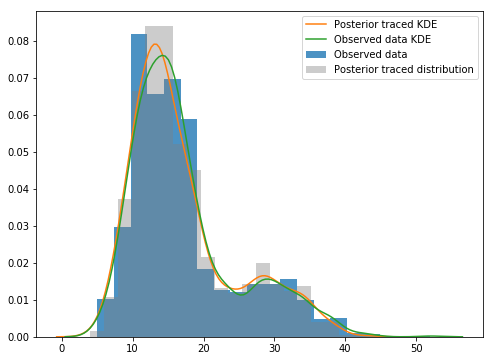

In [71]:
N = 1000

W = np.array([0.22, 0.78])

Lam = np.array([29.3, 13.7])

component = np.random.choice(Lam.size, size=N, p=W)
x = np.random.poisson(Lam[component], size=N)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(mixture, bins=20, normed=True, lw=0, alpha=.8, label='Observed data')
ax.hist(x, bins=20, normed=True, lw=0, alpha=0.4, color='gray', label='Posterior traced distribution')
sns.kdeplot(x, label='Posterior traced KDE')
sns.kdeplot(mixture, label='Observed data KDE')
plt.legend()
plt.show()

#  Predictive analysis to determine the cluster probability of each value

**To predict the probability of value x belonging to cluster 0 or cluster 1, we need to analyze the common area within the two poisson distributions.**

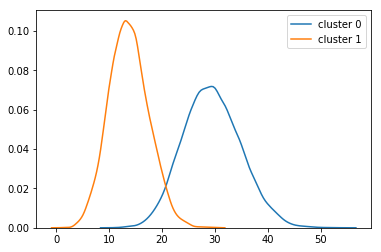

In [159]:
# Recreate distributions from trace
np.random.seed(seed=13)
x0 = pm.Poisson.dist(mu=trace['lam'][:,0]).random(100000)
x1 = pm.Poisson.dist(mu=trace['lam'][:,1]).random(100000)

sns.kdeplot(x0, label='cluster 0')
sns.kdeplot(x1, label='cluster 1')
# plt.xlim(20,22)
plt.legend()
plt.show()

Suppose we observe a new data point, say `x=22`, and we wish to calculate the probability of it being assigned to  cluster 1. Let's denote the assignment of x as Lx, which is equal to 0 or 1. We are interested in P(Lx=1|x=22).

According to Bayes theorem:
$$P(A\mid B) = \frac{P(B\mid A)P(A)}{P(B)}$$

In our case, A represents Lx=1 and B is the evidence we have: we observe that x=22. 

we are interested in asking "Is the probability that x is in cluster 1 greater than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters:
$$P(L_x=1\mid x=22) > P(L_x=0\mid x=22)$$

Which translates to:
$$\frac{P(x=22\mid L_x=1)P(L_x=1)}{P(x=22)} > \frac{P(x=22\mid L_x=0)P(L_x=0)}{P(x=22)}$$

As the denominators are equal, they can be ignored, so our formula is:

$${P(x=22\mid L_x=1)P(L_x=1)} > {P(x=22\mid L_x=0)P(L_x=0)}$$

P(Lx=0) is equal to:

In [152]:
trace['w'][:,0]

array([0.21897921, 0.21897921, 0.21957066, ..., 0.22237534, 0.22266458,
       0.21904755])

In [200]:
poisson_pmf = stats.poisson.pmf

prob_cluster_0 = trace['w'][:,0] # P(Lx=0)
prob_cluster_1 =  1 - prob_cluster_0

x=22

v = poisson_pmf(x, mu=trace['lam'][:,1]) * (prob_cluster_1) > \
    poisson_pmf(x, mu=trace['lam'][:,0]) * (prob_cluster_0)
    
print("Probability of belonging to cluster one when x=22: "+str(v.mean()))

Probability of belonging to cluster one when x=22: 0.8972


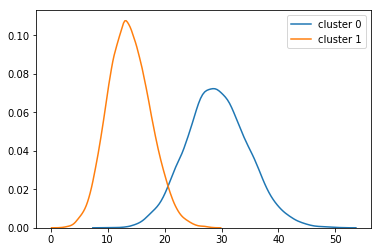

In [175]:
# Recreate distributions from trace
np.random.seed(seed=13452)
x0 = pm.Poisson.dist(mu=trace['lam'][:,0]).random(100000)
x1 = pm.Poisson.dist(mu=trace['lam'][:,1]).random(100000)

sns.kdeplot(x0, label='cluster 0')
sns.kdeplot(x1, label='cluster 1')
# plt.xlim(20,22)
plt.legend()
plt.show()

In [197]:
print("Although the two distributions intersect at approximately x=21.5, when x=22 it has 89% \
probability of belonging to cluster 1. This is because cluster 1 has 750 more data points than cluster 2, which \
allows us to be more confident about the values within it, even if they are at the tail of the distribution.") 

Although the two distributions intersect at approximately x=21.5, when x=22 it has 89% probability of belonging to cluster 1. This is because cluster 1 has 750 more data points than cluster 2, which allows us to be more confident about the values within it, even if they are at the tail of the distribution.
